<h1>
  <b>
    <p style="
        background-color: #1a1a2e;
        font-family: 'Helvetica', 'Arial', sans-serif;
        font-size: 140%;
        color: #ffffff;
        text-align: center;
        border-radius: 15px;
        padding: 20px;
        border-left: 8px solid #00b4d8;
        border-right: 8px solid #00b4d8;
        box-shadow: 0 6px 15px rgba(0,0,0,0.3);
        letter-spacing: 1.5px;
        font-weight: 700;
    ">
      CHEST X-RAY 
      <span style="
          background: linear-gradient(90deg, #ff4d4d, #ff9999);
          -webkit-background-clip: text;
          -webkit-text-fill-color: transparent;
      ">PNEUMONIA</span>
      DETECTION
    </p>
  </b>
</h1>


<img src="https://media.istockphoto.com/id/1137042463/photo/doctor-with-radiological-chest-x-ray-film-for-medical-diagnosis-on-patients-health-on-asthma.jpg?s=612x612&w=0&k=20&c=1kHU77IWWw0EYpnfMQI-iu_jBocPFTXnYs0HewwWwIQ=" style="width:100%">

# <b> <span style='color:dimgray'>Step 1 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Import Modules</span></b>


In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping
import warnings 
warnings.filterwarnings("ignore")

2026-02-20 15:18:49.399424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771600729.699021      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771600729.787917      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771600730.459558      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771600730.460187      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771600730.460191      55 computation_placer.cc:177] computation placer alr

# <b> <span style='color:dimgray'>Step 2 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Data Directories</span></b>


In [2]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

def create_df(directory):
    filepaths = []
    labels = []
    folds = os.listdir(directory)
    for fold in folds:
        f_path = os.path.join(directory, fold)
        imgs = os.listdir(f_path)
        for img in imgs:
            img_path = os.path.join(f_path, img)
            filepaths.append(img_path)
            labels.append(fold)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

df_train = create_df(train_dir)
df_test = create_df(test_dir)

# <b> <span style='color:dimgray'>Step 3 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Training, Validation & Test Dataset </span></b>


In [3]:
# training
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=(256, 256),
    batch_size=32)
# validation
validation_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=(256, 256),
    batch_size=32)
# test
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(256, 256),
    batch_size=32)

Found 5216 files belonging to 2 classes.
Using 4695 files for training.


2026-02-20 15:19:35.371023: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Found 624 files belonging to 2 classes.


# <b> <span style='color:dimgray'>Step 4 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Normalizing Pixel Valuess</span></b>


In [8]:
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# <b> <span style='color:dimgray'>Step 5 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Visual Count</span></b>


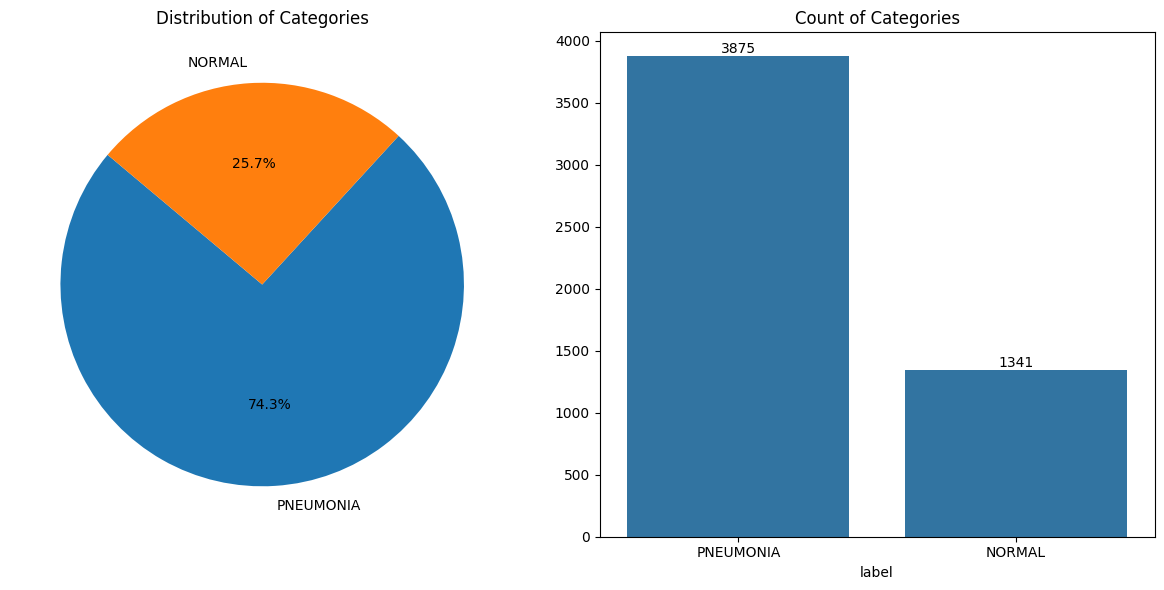

In [9]:
count = df_train['label'].value_counts()
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

sns.barplot(x=count.index, y=count.values, ax=axs[1])
axs[1].set_title('Count of Categories')

for p in axs[1].patches:
    axs[1].text(p.get_x() + p.get_width()/2., 
                 p.get_height() + 3, 
                 str(int(p.get_height())),
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

# <b> <span style='color:dimgray'>Step 6 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Train Images</span></b>

In [12]:
def visualize_images(path, num_images=4):
    image_filenames = os.listdir(path)
    num_images = min(num_images, len(image_filenames))
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')

    for i, image_filename in enumerate(image_filenames[:num_images]):
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)
        
        axes[i].imshow(image)
        axes[i].axis('off') 
        axes[i].set_title(image_filename) 

    plt.tight_layout()
    plt.show()

# <b> <span style='color:dimgray'>Step 7 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Normal Images</span></b>


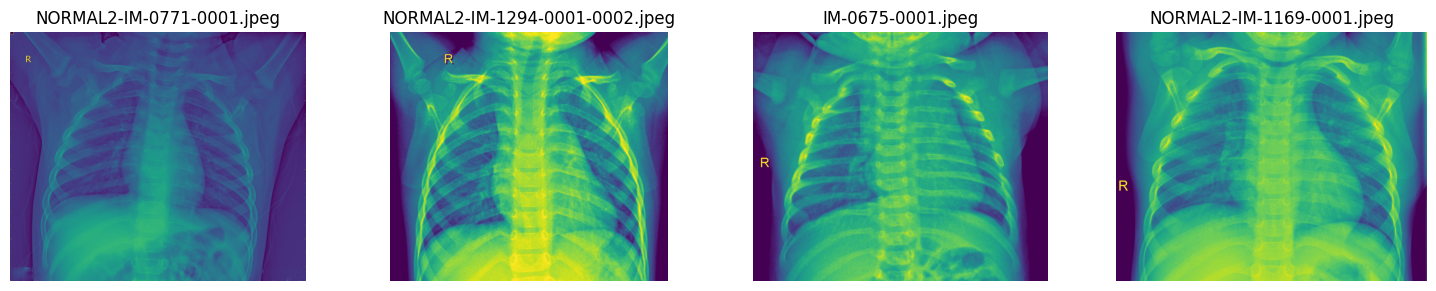

In [11]:
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"
visualize_images(path_to_visualize, num_images=4)

# <b> <span style='color:dimgray'>Step 8 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Pneumonia Image</span></b>


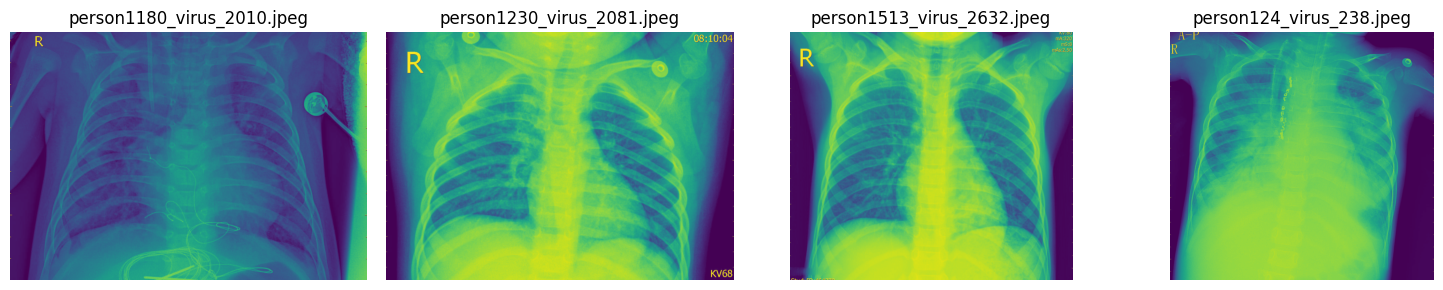

In [13]:
path_to_visualize = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"
visualize_images(path_to_visualize, num_images=4)

# <b> <span style='color:dimgray'>Step 9 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Building DenseNet121 Model</span></b>


In [17]:
base_model = DenseNet121(weights='imagenet', include_top=False, pooling='max', input_shape=(256, 256, 3))
base_model.trainable = False

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/densenet/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno -3] Temporary failure in name resolution

# <b> <span style='color:dimgray'>Step 10 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Sequential Model Architecture</span></b>


In [16]:
model = Sequential([
    base_model,
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

NameError: name 'base_model' is not defined

# <b> <span style='color:dimgray'>Step 11 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Early Stopping</span></b>


In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# <b> <span style='color:dimgray'>Step 12 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Model Training</span></b>


In [20]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=validation_ds,
    callbacks=[early_stopping])

NameError: name 'model' is not defined

# <b> <span style='color:dimgray'>Step 13 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Training History</span></b>


NameError: name 'history' is not defined

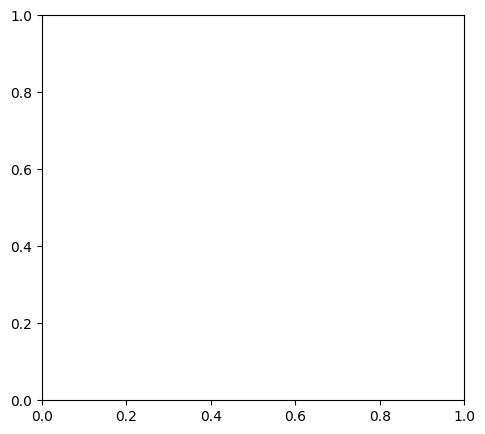

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# <b> <span style='color:dimgray'>Step 14 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Model Evaluation on Test Set</span></b>


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# <b> <span style='color:dimgray'>Step 15 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Grad-CAM Heatmap</span></b>


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    base_m = model.layers[0]
    grad_model = tf.keras.models.Model([base_m.inputs], [base_m.get_layer(last_conv_layer_name).output, base_m.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, base_output = grad_model(img_array)
        x = base_output
        for layer in model.layers[1:]: x = layer(x)
        class_channel = x[:, 0]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# <b> <span style='color:dimgray'>Step 16 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Prediction with Highlights</span></b>


In [ ]:
def predict_and_compare(img_path, model):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_res = cv2.resize(img_rgb, (256, 256))
    img_array = np.expand_dims(img_res.astype(np.float32) / 255.0, axis=0)

    score = model.predict(img_array)[0][0]
    is_p = score > 0.5
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_rgb); ax[0].set_title(f"Original\nPred: {'PNEUMONIA' if is_p else 'NORMAL'}"); ax[0].axis('off')

    if is_p:
        heatmap = make_gradcam_heatmap(img_array, model, 'relu')
        heatmap = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))
        jet_heatmap = cm.get_cmap("jet")(np.arange(256))[:, :3][np.uint8(255 * heatmap)]
        jet_heatmap = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.array_to_img(jet_heatmap).resize((img_rgb.shape[1], img_rgb.shape[0])))
        
        superimposed = jet_heatmap * 0.4 + img_rgb
        ax[1].imshow(tf.keras.preprocessing.image.array_to_img(superimposed))
        ax[1].set_title(f"Infected Areas (Score: {score*100:.1f}%)")
    else:
        ax[1].imshow(img_rgb); ax[1].set_title("No Infection Detected")
    ax[1].axis('off'); plt.show()

# <b> <span style='color:dimgray'>Step 17 </span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Test Visualization</span></b>


In [ ]:
p_img = os.path.join(test_dir, 'PNEUMONIA', os.listdir(os.path.join(test_dir, 'PNEUMONIA'))[2])
predict_and_compare(p_img, model)

# <b> <span style='color:dimgray'>Step 18</span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Saving the Model</span></b>


In [ ]:
# Model ko .h5 format mein save karein taake API mein load ho sake
model_name = 'pneumonia_detection_model.keras'
model.save(model_name)
print(f"Model saved successfully as {model_name}")

# <b> <span style='color:dimgray'>Step 19</span> <span style='color:crimson'>|</span> <span style='color:#53599A'>Upload on Hugging Face</span></b>

In [ ]:
!pip install huggingface_hub -q

In [ ]:
# Kaggle Secrets
from kaggle_secrets import UserSecretsClient
from huggingface_hub import HfApi

HF_TOKEN = UserSecretsClient().get_secret("HF_TOKEN")

HF_USERNAME = "DanishMubashar"
MODEL_REPO_NAME = "chest-xray-pneumonia-detection-DenseNet121"
REPO_ID = f"{HF_USERNAME}/{MODEL_REPO_NAME}"

api = HfApi(token=HF_TOKEN)

output_dir = "/kaggle/working/" 
# Save model
model.save(f"{output_dir}/pneumonia_detection_model.keras")

# Create repo 
api.create_repo(repo_id=REPO_ID, repo_type="model", exist_ok=True)

# Upload the whole output_dir
api.upload_folder(
    repo_id=REPO_ID,
    repo_type="model",
    folder_path=str(output_dir),
    path_in_repo="."
)

print("Done. Model repo:", REPO_ID)